In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import *
import scipy as sp
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.decomposition import *
from sklearn.metrics import *
from sklearn.neighbors import *
from collections import *
from pyclust import *
from sklearn.manifold import *
from sklearn.cluster import KMeans
from module.EKmeans import *
from module.CTree import *
import datetime
from collections import *

DATA_PATH = './trade_new.csv'

_col = {
    'uid':'uid',
    'tran_time':'sldatime', #
    'gender_age':'cmrid',
    'vipno':'vipno', #
    'itemno':'pluno', #
    'amount':'amt', #
    'quantity':'qty', #
    'brandno':'bndno', #
}

_col_class = {
    'class1':'class1',
    'class2':'class2',
    'class3':'class3',
    'class4':'class4',
    'class5':'class5',
}

_col2 ={**_col,**_col_class}

print('columns',_col2)

CTree.py init
columns {'uid': 'uid', 'tran_time': 'sldatime', 'gender_age': 'cmrid', 'vipno': 'vipno', 'itemno': 'pluno', 'amount': 'amt', 'quantity': 'qty', 'brandno': 'bndno', 'class1': 'class1', 'class2': 'class2', 'class3': 'class3', 'class4': 'class4', 'class5': 'class5'}


第一问

In [3]:
df = pd.read_csv(DATA_PATH)
df = df[_col.values()]
new_df = pd.DataFrame([],columns=_col2.values())


category = df[_col2['itemno']].values.astype('str')
category = np.array(list(map(lambda x:np.array([x[:2],x[:3],x[:4],x[:5],x[5:]]),category)))
category = pd.DataFrame(category,columns=_col_class.values())
if (category.index.start == df.index.start) and \
    (category.index.stop == df.index.stop):
    new_df = df.join(category)

df_amount_sum = new_df.groupby([_col2['vipno'],_col2['class1'],_col2['class2'],_col2['class3'],_col2['class4']],as_index=False).agg({
    _col2['amount']:sum
})
df_amount_sum3 = new_df.groupby([_col2['vipno'],_col2['class1'],_col2['class2'],_col2['class3']],as_index=False).agg({
    _col2['amount']:sum
})
df_amount_sum2 = new_df.groupby([_col2['vipno'],_col2['class1'],_col2['class2']],as_index=False).agg({
    _col2['amount']:sum
})
df_amount_sum1 = new_df.groupby([_col2['vipno'],_col2['class1']],as_index=False).agg({
    _col2['amount']:sum
})
df_amount = [df_amount_sum1, df_amount_sum2, df_amount_sum3, df_amount_sum]
del df
# df_amount_sum.to_csv('./result/a1-amount_sum.csv')

第二问

In [4]:
set_vipno = set(df_amount_sum[_col2['vipno']])
mapping_index_v = {i:idx for (idx,i) in zip(range(len(set_vipno)),set_vipno)}


def aggByUser(category='class4'):
    global set_vipno,df_amount,_col2
    map_single = {v:{} for v in set_vipno}
    df_temp = df_amount[ int(category[-1])-1 ]
    for v in set_vipno:
        lst_v = df_temp.loc[ df_temp[_col2['vipno']]==v ]
        for idx,row in lst_v.iterrows():
            map_single[v][ row[ _col2[ category ] ] ] = row[ _col2['amount'] ]
    return map_single


def computeUserFeatureOfClass(category='class4'):
    global df_amount,mapping_index_v,_col2
    set_class_i = set(new_df[_col2[ category ]])
    mapping_index_class_i = {i:idx for (idx,i) in zip(range(len(set_class_i)),set_class_i)}
    mat_userFeature = np.array([[0.0 for i in range(len(set_class_i))] for j in range(len(set_vipno))])
    for idx,r in df_amount[ int(category[-1])-1 ].iterrows():
        mat_userFeature[ mapping_index_v[ r[ _col2['vipno'] ] ] ][ mapping_index_class_i[ r[ _col2[category] ] ] ] = r[ _col2['amount'] ]
    return mat_userFeature


def computeJaccardDistance(a,b):
    return 1-np.sum(np.min([a,b],0))/np.sum(np.max([a,b],0))


def computeJaccardMatrix(mat_userFeature):
    global set_vipno,map_single,mapping_index_v,D
    mat_jaccard = np.array([[0 for i in range(len(set_vipno))] for j in range(len(set_vipno))]).astype('float')
    for v1 in set_vipno:
        for v2 in set_vipno:
            jaccard_pairwise_dist = compute_distance(a=mat_userFeature[mapping_index_v[v1]],b=mat_userFeature[mapping_index_v[v2]],D=D,metric='jaccard')
            mat_jaccard[mapping_index_v[v1]][mapping_index_v[v2]] = mat_jaccard[mapping_index_v[v2]][mapping_index_v[v1]] = jaccard_pairwise_dist
    return mat_jaccard

def compute_distance(a,b,D,metric='jaccard'):
    if metric=='jaccard':
        return computeJaccardDistance(a,b)
    elif metric=='euclidean':
        return norm(a-b)
    elif metric=='cos':
        score = [computeJaccardDistance(a[:D[0]],b[:D[0]]),
                computeJaccardDistance(a[D[0]:D[1]],b[D[0]:D[1]]),
                computeJaccardDistance(a[D[1]:D[2]],b[D[1]:D[2]]),
                computeJaccardDistance(a[D[2]:D[3]],b[D[2]:D[3]])]
#             print(score)
        return sum(score)/4

In [5]:
mat_userFeature = computeUserFeatureOfClass('class4')

In [6]:
D = None
mat_jaccard = computeJaccardMatrix(mat_userFeature)

Text(0.5, 1.0, '1-Jaccard Distance Distribution')

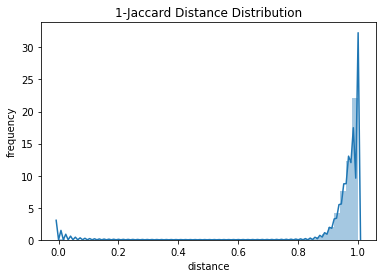

In [7]:
d = mat_jaccard
d = d.ravel()
plt.figure()
sns.distplot(d,bins=50)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.title('1-Jaccard Distance Distribution')

第三问

In [11]:
class EKmeans():
    def __init__(self,X,D,method='jaccard',n_centers=2,max_iters=1000,tol=1e-20,verbose=0):
        self.n_centers = n_centers
        self.max_iters = max_iters
        self.D = D
        self.method = method
        self.X = X
        self.clusters = np.array([-1 for i in range(X.shape[0])])
        self.centers = self.X[np.random.permutation(X.shape[0])[:self.n_centers]]
        self.pre_centers = []
        self.debug = []
        self.lr = 0.34
        self.tol = tol
        self.verbose = verbose
        return
    
    def metrics_compactness(self):
        s = 0.0
        for c in range(self.n_centers):
            idx_cluster = np.where(self.clusters==c)[0]
            for a in self.X[ idx_cluster ]:
                dst = compute_distance(a=a,b=self.centers[c],D=self.D,metric=self.method)
                s += dst*1.0/len(idx_cluster)
        return s
                
    def __update_centers(self,smooth=True):
        self.pre_centers = np.array(self.centers)
        for c in range(self.n_centers):
            temp = self.X[ np.where(self.clusters==c)[0] ]
            if len(temp):
                self.centers[c] = np.array([ np.mean( temp, 0 ) ])
        if smooth:
            self.centers = (self.centers-self.pre_centers)*self.lr + self.pre_centers
        return
    
    def __log(self,x):
        if self.verbose:
            print(x)
        return
    
    def fit(self):
        for kiter in range(self.max_iters):
            self.__log('iteration %d'%kiter)
            for i in range(self.X.shape[0]):
                d_min_dist = 1e10
                record_node = -1
                for idx,c in zip(range(len(self.centers)),self.centers):
                    dst = compute_distance(a=self.X[i],b=c,D=self.D,metric=self.method)
                    if dst<d_min_dist:
                        d_min_dist = dst
                        record_node = idx
                self.clusters[i] = record_node
            self.__update_centers()
            move_dist = np.mean(norm(self.pre_centers-self.centers,axis=1))
            self.debug.append(move_dist)
            if (kiter - kiter//20 *20 ==1) and move_dist<self.tol:
                break
            if kiter==10:
                pass
        return

In [12]:
def KmeansCluster(n_centers,method='cos',max_iters=500):
    global mat_userFeature,D
    if method=='jaccard':
        kmeans = EKmeans(mat_userFeature[-1],None,n_centers=n_centers,max_iters=max_iters)
    elif method=='cos':
        kmeans = EKmeans(np.hstack(mat_userFeature),D,n_centers=n_centers,max_iters=max_iters,method='cos')
    elif method=='euclidean':
        kmeans = EKmeans(mat_userFeature[-1],None,n_centers=n_centers,max_iters=max_iters,method='euclidean')
    kmeans.fit()
    return kmeans

In [13]:
mat_userFeature = [computeUserFeatureOfClass('class1'),
                   computeUserFeatureOfClass('class2'),
                   computeUserFeatureOfClass('class3'),
                   computeUserFeatureOfClass('class4')
                  ]
res = []
for nn in range(2,20):
    print('param ',nn)
    kmeans = KmeansCluster(nn,'jaccard',1000)
    sil = silhouette_score(mat_jaccard,labels=kmeans.clusters,metric='precomputed')
    com = kmeans.metrics_compactness() 
    res.append({'sil':sil,'com':com,'nn':nn})
    


param  2
param  3
param  4
param  5
param  6
param  7
param  8
param  9
param  10
param  11
param  12
param  13
param  14
param  15
param  16
param  17
param  18
param  19


In [14]:
_ = [print(r) for r in res]

{'sil': 0.007610753245970855, 'com': 1.869843470755909, 'nn': 2}
{'sil': 0.010332723296873228, 'com': 2.790711173708524, 'nn': 3}
{'sil': 0.009628682459347955, 'com': 3.7024883305313403, 'nn': 4}
{'sil': 0.010051255556579855, 'com': 4.636470124953068, 'nn': 5}
{'sil': 0.01089607675726066, 'com': 5.495188622333691, 'nn': 6}
{'sil': 0.009026469507654717, 'com': 6.439431574505368, 'nn': 7}
{'sil': 0.009957522334465898, 'com': 7.333609698513056, 'nn': 8}
{'sil': 0.01006949705055751, 'com': 8.256420216087855, 'nn': 9}
{'sil': 0.010490926790739093, 'com': 9.128690542475722, 'nn': 10}
{'sil': 0.011369810657659525, 'com': 10.004972956095543, 'nn': 11}
{'sil': 0.010551375052051873, 'com': 10.865682833417736, 'nn': 12}
{'sil': 0.010370364191472518, 'com': 11.842341825818261, 'nn': 13}
{'sil': 0.01124552094378586, 'com': 12.71626284081211, 'nn': 14}
{'sil': 0.00996301187895114, 'com': 13.539984414863588, 'nn': 15}
{'sil': 0.010747725054148824, 'com': 14.373044794755902, 'nn': 16}
{'sil': 0.011103

In [13]:
res = a

Text(0.5, 1.0, '1-Jaccard Kmeans')

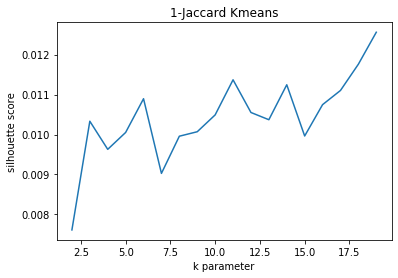

In [16]:
X = np.array([[r['nn'],r['sil'],r['com']] for r in res])
sns.lineplot(x=X[:,0],y=X[:,1])
plt.xlabel('k parameter')
plt.ylabel('silhouette score')
plt.title('1-Jaccard Kmeans')

Text(0.5, 1.0, '1-Jaccard Kmeans')

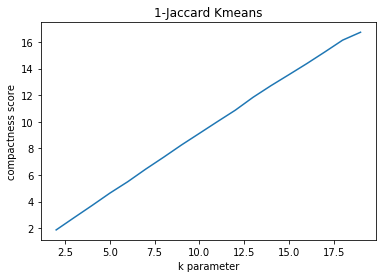

In [17]:
X = np.array([[r['nn'],r['sil'],r['com']] for r in res])
sns.lineplot(x=X[:,0],y=X[:,2])
plt.xlabel('k parameter')
plt.ylabel('compactness score')
plt.title('1-Jaccard Kmeans')